# Doing ordinary least squares and AR(1) modeling

In [2]:
# The usual boilerplate
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline
# - set gray colormap and nearest neighbor interpolation by default
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

In [3]:
# Imports from nipy
import nipy
from nipy.modalities.fmri.design import block_design, stack_designs
from nipy.modalities.fmri import hrf
from nipy.algorithms.statistics.api import (OLSModel, ARModel, make_recarray)
from nipy.modalities.fmri.design_matrix import _cosine_drift as dft_basis

First we get the raw functional data and drop the first four scans, as dummy scans.

In [4]:
n_dummies = 4
func_img = nipy.load_image('ds114_sub009_t2r1.nii')
func_img = func_img[..., n_dummies:]
func_img.shape

(64, 64, 30, 169)

We get the times at which each remaining volume was acquired relative to the start of the first volume.  The first volume is the first of the four dummy scans we dropped:

In [5]:
TR = 2.5
n_vols = func_img.shape[-1]
volume_times = np.arange(n_vols) * TR + n_dummies * TR

We make the volume times into a structured array with field name `t`, so that nipy knows this is an array of time values.

In [31]:
volume_times_rec = make_recarray(volume_times, 't')
volume_times_rec

array([(10.0,), (12.5,), (15.0,), (17.5,), (20.0,), (22.5,), (25.0,),
       (27.5,), (30.0,), (32.5,), (35.0,), (37.5,), (40.0,), (42.5,),
       (45.0,), (47.5,), (50.0,), (52.5,), (55.0,), (57.5,), (60.0,),
       (62.5,), (65.0,), (67.5,), (70.0,), (72.5,), (75.0,), (77.5,),
       (80.0,), (82.5,), (85.0,), (87.5,), (90.0,), (92.5,), (95.0,),
       (97.5,), (100.0,), (102.5,), (105.0,), (107.5,), (110.0,), (112.5,),
       (115.0,), (117.5,), (120.0,), (122.5,), (125.0,), (127.5,),
       (130.0,), (132.5,), (135.0,), (137.5,), (140.0,), (142.5,),
       (145.0,), (147.5,), (150.0,), (152.5,), (155.0,), (157.5,),
       (160.0,), (162.5,), (165.0,), (167.5,), (170.0,), (172.5,),
       (175.0,), (177.5,), (180.0,), (182.5,), (185.0,), (187.5,),
       (190.0,), (192.5,), (195.0,), (197.5,), (200.0,), (202.5,),
       (205.0,), (207.5,), (210.0,), (212.5,), (215.0,), (217.5,),
       (220.0,), (222.5,), (225.0,), (227.5,), (230.0,), (232.5,),
       (235.0,), (237.5,), (240.0,), (

Next we make the definition of a block design, in a format nipy understands.

Here are the onsets of the blocks and their durations, in the standard OpenFMRI format:

In [9]:
block_defs = np.loadtxt('ds114_sub009_t2r1_cond.txt')
block_defs

array([[  10.,   30.,    1.],
       [  70.,   30.,    1.],
       [ 130.,   30.,    1.],
       [ 190.,   30.,    1.],
       [ 250.,   30.,    1.],
       [ 310.,   30.,    1.],
       [ 370.,   30.,    1.]])

Make this into a structured array with fields `start` (onset time) and `stop` (offset time):

In [10]:
onsets, durations, amplitudes = block_defs.T
block_spec_arr = np.column_stack((onsets, onsets + durations))
block_spec = make_recarray(block_spec_arr, ('start', 'end'))
block_spec

array([[(10.0, 40.0)],
       [(70.0, 100.0)],
       [(130.0, 160.0)],
       [(190.0, 220.0)],
       [(250.0, 280.0)],
       [(310.0, 340.0)],
       [(370.0, 400.0)]], 
      dtype=[('start', '<f8'), ('end', '<f8')])

Feed this block definition into the nipy utility for constructing the design matrix for a block design.

We'll use the SPM HRF definition, but you can explore the `hrf` model for other HRF definitions we could have used:

In [11]:
X_exper, cons_exper = block_design(block_spec, 
                                   volume_times_rec,
                                   hrfs=(hrf.spm,))

Because this is a single condition, this design is a single regressor - the block on/off step function convolved with the HRF:

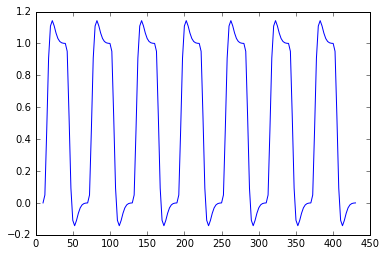

In [12]:
plt.plot(volume_times, X_exper)

Nipy made the contrast for this part of the design.  In this case it's just a single value == 1 (more or less!) but if we had included other columns in the block definition, these would have been factor levels, and there could be more contrasts here, for main effects and interactions:

In [13]:
cons_exper

{'constant_0': array(0.9999999999999998)}

Model the low-frequency drift with the discrete cosine basis.  This is the default model used by SPM. See https://en.wikipedia.org/wiki/Discrete_cosine_transform.

In [14]:
# 128 seconds wavelength cut-off high-pass filter.
drift = dft_basis(128, volume_times)

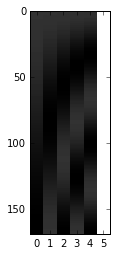

In [15]:
plt.imshow(drift, aspect=0.1)

In [16]:
# Stack the experimental and drift designs, keeping track of
# the columns in the contrast matrix.
X, cons = stack_designs((X_exper, cons_exper), (drift, {}))

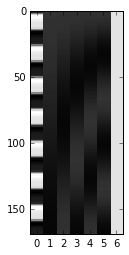

In [17]:
plt.imshow(X, aspect=0.1)

First we do an OLS fit of this model to the data, rearranged to a time by voxel array:

In [18]:
model_0 = OLSModel(X)

In [19]:
data = func_img.get_data()
data_2d = data.reshape(-1, n_vols).T
result = model_0.fit(data_2d)
result

In [20]:
betas_2d = result.theta
betas_2d.shape

(7, 122880)

We rearrange the beta matrix from number of parameters (==P) by voxel, to (I, J, K, P).

In [21]:
vol_shape = data.shape[:3]
betas_4d = betas_2d.T.reshape(vol_shape + (-1,))

Here is the center slice from the first parameter volume (p=0).  This is the parameter for the HRF regressor.  It shows some activation in the left frontal lobe.

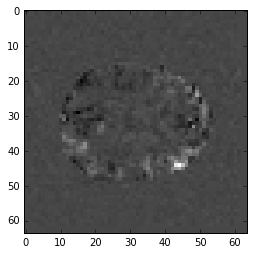

In [22]:
plt.imshow(betas_4d[:, :, 15, 0])

Next we make an estimate for the AR(1) parameter from the residuals of the OLS model.

In [23]:
result.resid.shape

(169, 122880)

In [24]:
# Estimate AR(1) coefficient
lag_1 = (result.resid[1:] * result.resid[:-1]).sum(axis=0)
resid_ss = (result.resid**2).sum(axis=0)
nz_ss = resid_ss != 0
ar1_estimate = lag_1
ar1_estimate[~nz_ss] = 0
ar1_estimate[nz_ss] /= resid_ss[nz_ss]

In [25]:
ar1_estimate.shape

(122880,)

In [26]:
# We round AR(1) to nearest one-hundredth and group voxels by their rounded
# AR(1) value, fitting an AR(1) model to each batch of voxels.
ar1_estimate = np.round(ar1_estimate * 100) / 100.

In [27]:
white_betas_2d = np.zeros_like(betas_2d)
# Loop across bins estimating model for each
for ar_val in np.unique(ar1_estimate):
    ar_mask = ar1_estimate == ar_val
    m = ARModel(X, ar_val)
    d = data_2d[:,ar_mask]
    results = m.fit(d)
    white_betas_2d[:, ar_mask] = results.theta

Here are the estimates for the first parameter (HRF parameter) after AR(1) modeling:

In [28]:
white_betas_4d = white_betas_2d.T.reshape(vol_shape + (-1,))

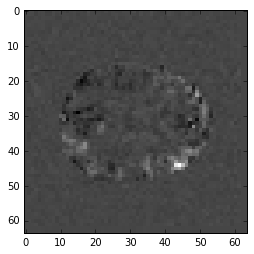

In [29]:
plt.imshow(white_betas_4d[:, :, 15, 0])

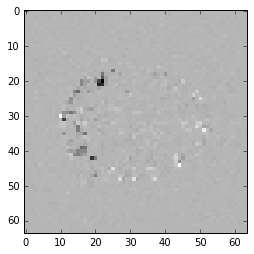

In [30]:
plt.imshow(white_betas_4d[:, :, 15, 0] - betas_4d[:, :, 15, 0])